In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from btc_cycles import Bitcoin
from btc_cycles.core.halvings import Halvings, get_halving_data

In [3]:
btc = Bitcoin()

In [4]:
get_halving_data()

(datetime.datetime(2028, 3, 16, 4, 20, 24, tzinfo=datetime.timezone.utc),
 1050000)

In [5]:
Halvings().data

,block,reward,Date,cycle_length,cycle_id
0,0,50,2009-01-03 00:00:00+00:00,1425.0,1
1,210000,25.0,2012-11-28 00:00:00+00:00,1319.0,2
2,420000,12.5,2016-07-09 00:00:00+00:00,1402.0,3
3,630000,6.25,2020-05-11 00:00:00+00:00,1440.0,4
4,840000,3.125,2024-04-20 12:09:27+00:00,1425.0,5
5,1050000,1.5625,2028-03-16 04:20:24+00:00,NaN,6
6,1260000,0.78125,NaT,NaN,7
7,1470000,0.390625,NaT,NaN,8
8,1680000,0.195312,NaT,NaN,9
9,1890000,0.097656,NaT,NaN,10


In [6]:
btc.prices

,Date,Close,block,reward,cycle_length,cycle_id,Halving,ATH,distance_ath_perc,cycle_progress
0,2013-04-28 00:00:00+00:00,127.954255,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,127.954255,0.000000,0.114481
1,2013-04-29 00:00:00+00:00,144.539993,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,0.000000,0.115239
2,2013-04-30 00:00:00+00:00,139.000000,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,-0.038328,0.115997
3,2013-05-01 00:00:00+00:00,116.989998,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,-0.190605,0.116755
4,2013-05-02 00:00:00+00:00,105.209999,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,-0.272105,0.117513
...,...,...,...,...,...,...,...,...,...,...
4013,2024-04-23 00:00:00+00:00,66407.271799,840000.0,3.125,1425.0,5.0,2024-04-20 12:09:27+00:00,73083.501328,-0.091351,0.001404
4014,2024-04-24 00:00:00+00:00,64276.897415,840000.0,3.125,1425.0,5.0,2024-04-20 12:09:27+00:00,73083.501328,-0.120501,0.002105
4015,2024-04-25 00:00:00+00:00,64481.706644,840000.0,3.125,1425.0,5.0,2024-04-20 12:09:27+00:00,73083.501328,-0.117698,0.002807
4016,2024-04-26 00:00:00+00:00,63755.321332,840000.0,3.125,1425.0,5.0,2024-04-20 12:09:27+00:00,73083.501328,-0.127637,0.003509


/home/runner/work/btc-cycles/btc-cycles/btc_cycles/artist/static.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.f.tight_layout()


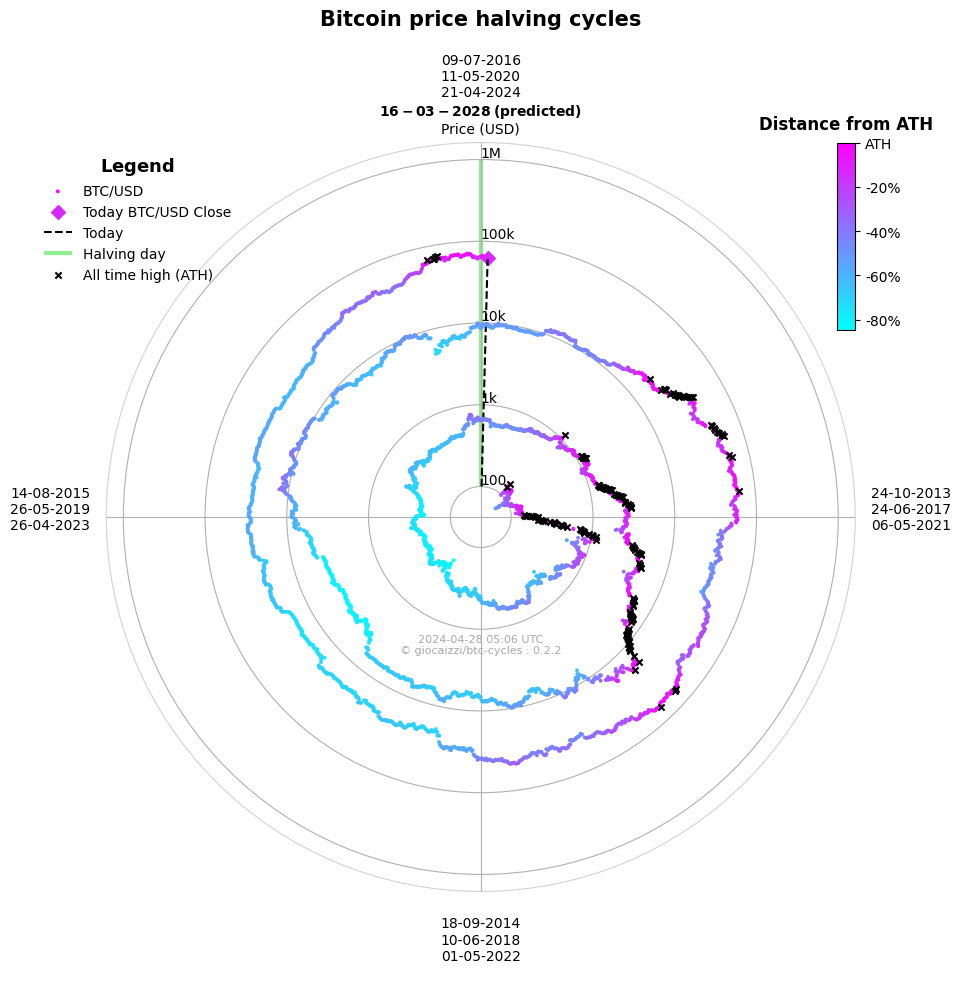

In [7]:
fig = btc.plot()
# # fig is a matplotlib figure object
fig.savefig("bitcoin.png")